## Part 2

# Quantum Machine Learning
<br>
<br>

You can find a copy of this presentation at

https://github.com/grossiM/LAB_Quantum_Computation22/tree/main

michele.grossi@cern.ch

### Installing qiskit-machine-learning

Anaconda or a pyenv is recommended to manage all dependencies.

*Command:* `pip install qiskit-machine-learning`

*Python version:* 3.9+

# Quantum Neural Networks

## Overview
This notebook provides a quick introduction to quantum neural network (QNN) implementations provided in `qiskit-machine-learning`, and how they can be integrated into basic quantum machine learning (QML) workflows.

The tutorial is structured as follows:

1. [Introduction](#1.-Introduction)
2. [How to Instantiate QNNs](#2.-How-to-Instantiate-QNNs)

## 1. Introduction

### 1.1. Quantum vs. Classical Neural Networks

Classical neural networks are algorithmic models inspired by the human brain that can be trained to recognize patterns in data and learn to solve complex problems. They are based on a series of interconnected nodes, or *neurons*, organized in a layered structure, with parameters that can be learned by applying machine or deep learning training strategies.

The motivation behind quantum machine learning (QML) is to integrate notions from quantum computing and classical machine learning to open the way for new and improved learning schemes. QNNs apply this generic principle by combining classical neural networks and parametrized quantum circuits. Because they lie at an intersection between two fields, QNNs can be viewed from two perspectives:

- From a **machine learning perspective**, QNNs are, once again, algorithmic models that can be trained to find hidden patterns in data in a similar manner to their classical counterparts. These models can **load** classical data (**inputs**) into a quantum state, and later **process** it with quantum gates parametrized by **trainable weights**. Figure 1 shows a generic QNN example including the data loading and processing steps. The output from measuring this state can then be plugged into a loss function to train the weights through backpropagation.

- From a **quantum computing perspective**, QNNs are quantum algorithms based on parametrized quantum circuits that can be trained in a variational manner using classical optimizers. These circuits contain a **feature map** (with input parameters) and an **ansatz** (with trainable weights), as seen in Figure 1.

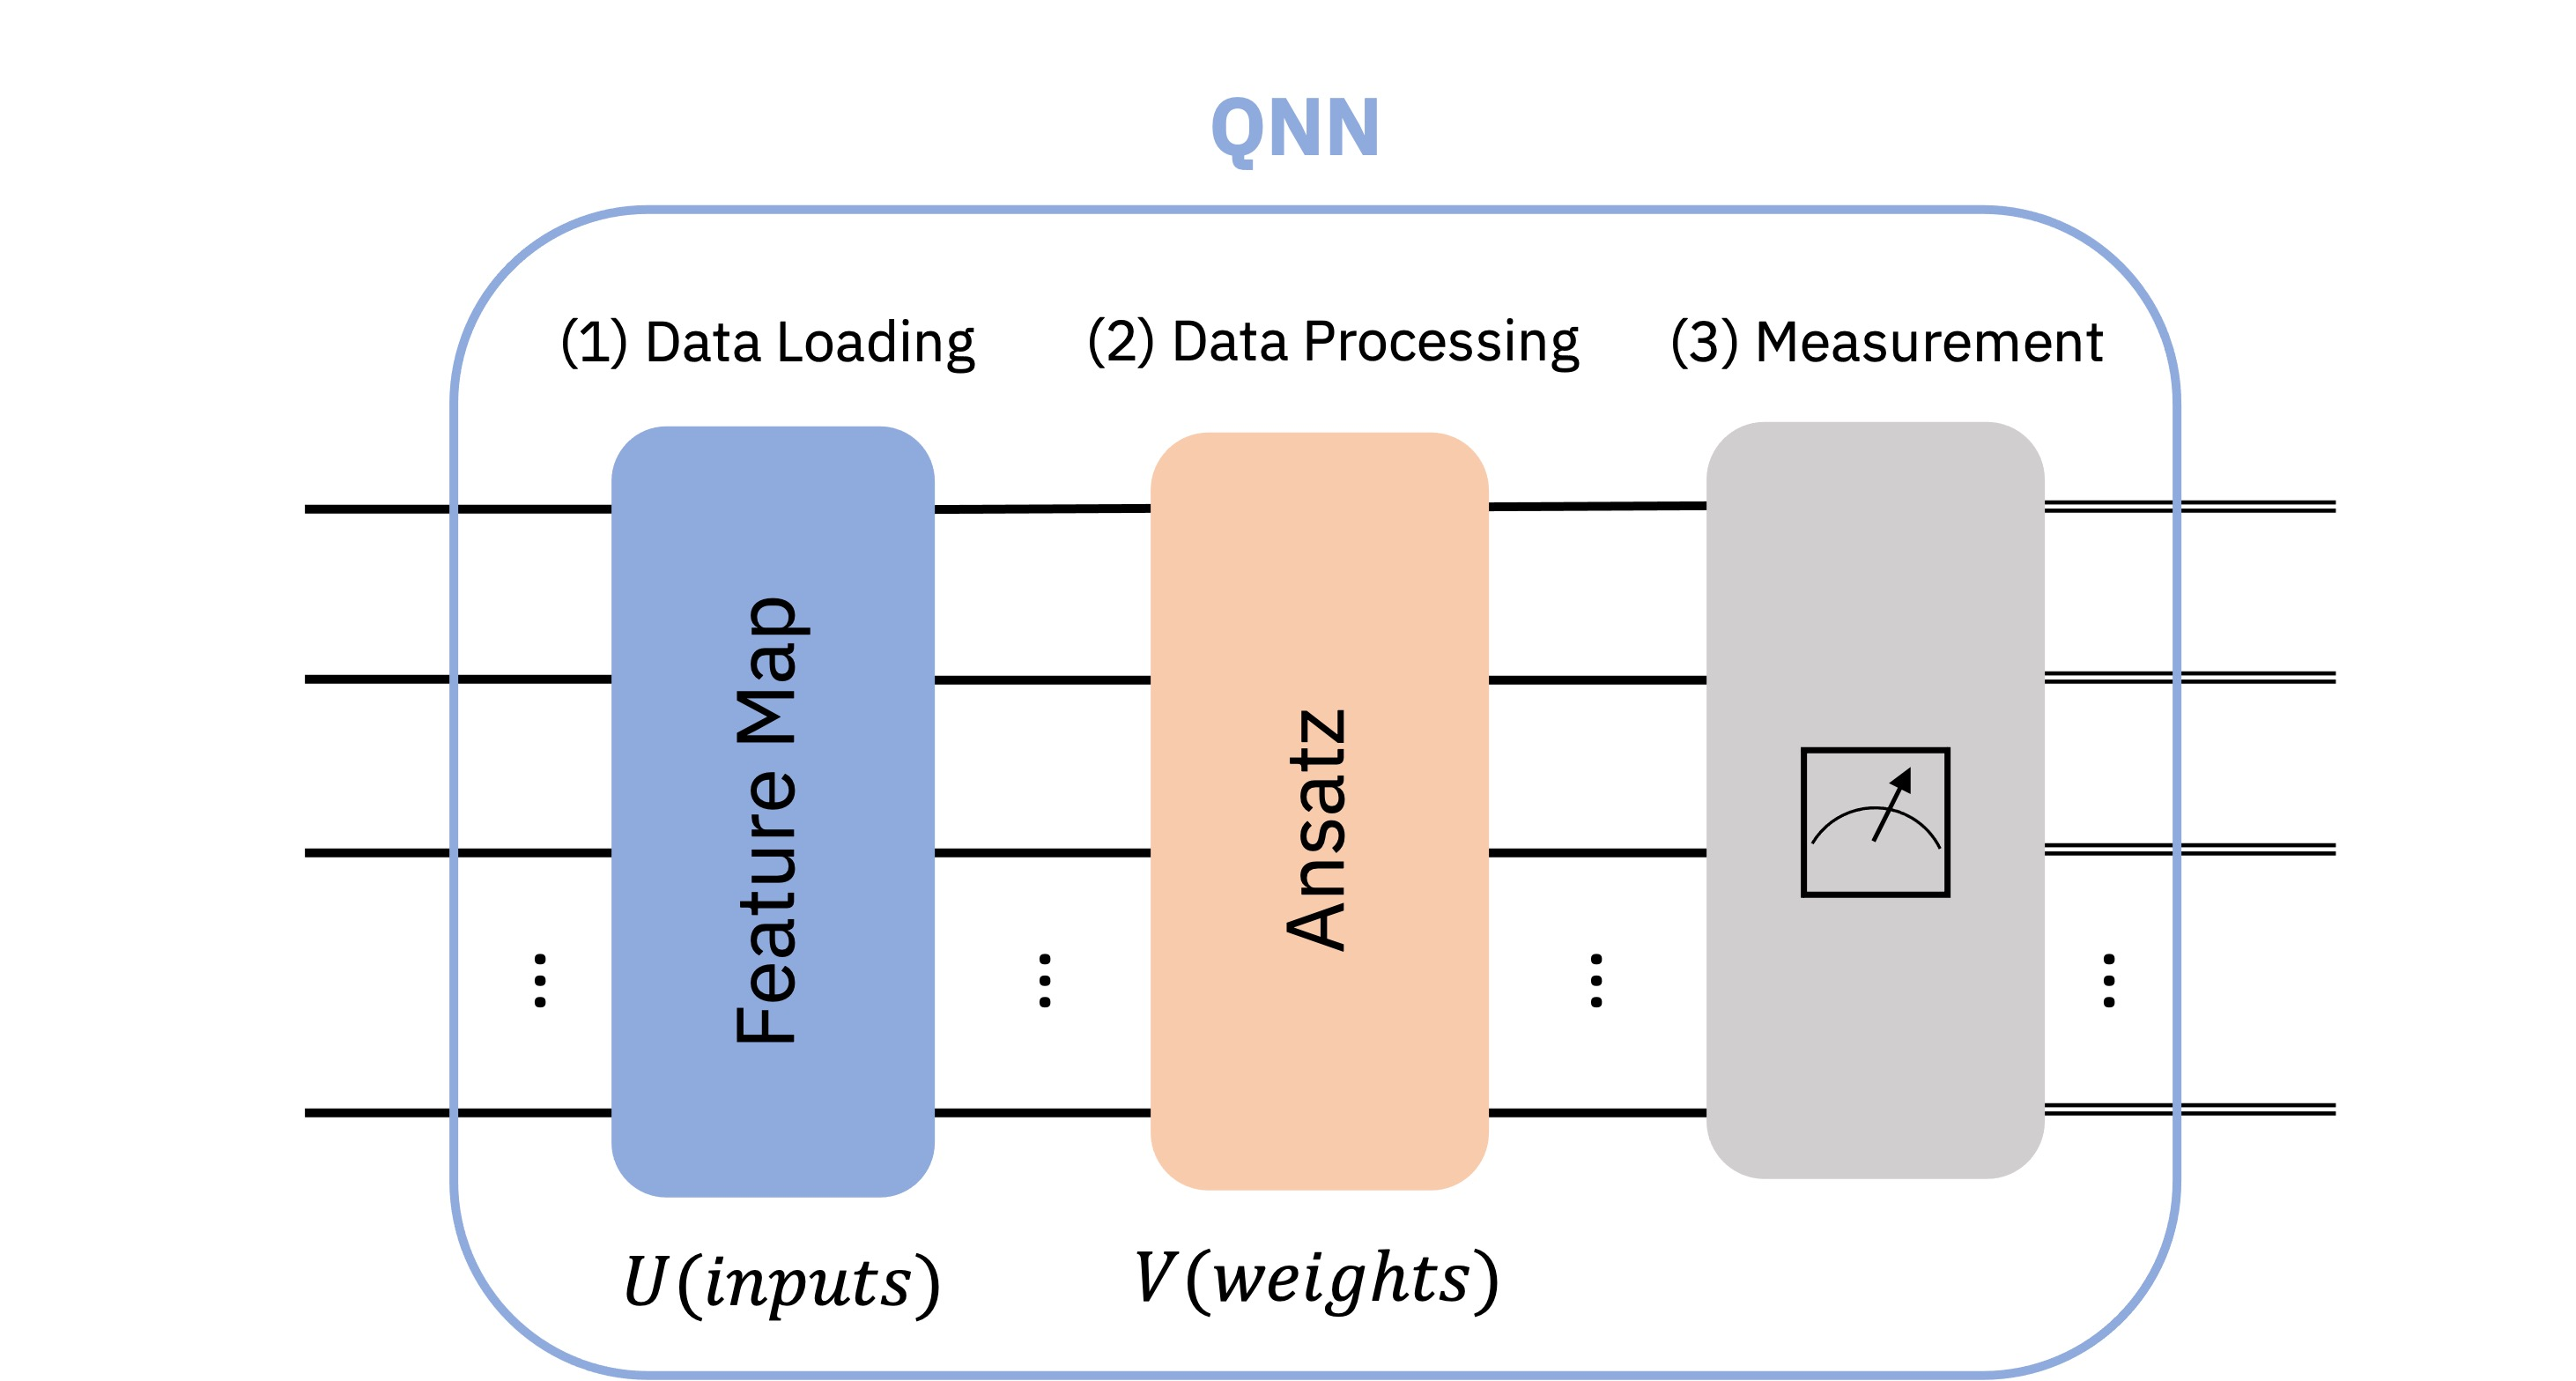


*Figure 1. Generic quantum neural network (QNN) structure.*

As you can see, these two perspectives are complementary, and do not necessarily rely on strict definitions of concepts such as "quantum neuron" or what constitutes a QNN's "layer".

### 1.2. Implementation in `qiskit-machine-learning`

The QNNs in `qiskit-machine-learning` are meant as application-agnostic computational units that can be used for different use cases, and their setup will depend on the application they are needed for. The module contains an interface for the QNNs and two specific implementations:

1. [NeuralNetwork](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.NeuralNetwork.html): The interface for neural networks. This is an abstract class all QNNs inherit from.
2. [EstimatorQNN](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.EstimatorQNN.html): A network based on the evaluation of quantum mechanical observables.
3. [SamplerQNN](https://qiskit.org/documentation/machine-learning/locale/fr_FR/stubs/qiskit_machine_learning.neural_networks.SamplerQNN.html): A network based on the samples resulting from measuring a quantum circuit.


These implementations are based on the [qiskit primitives](https://qiskit.org/documentation/apidoc/primitives.html). The primitives are the entry point to run QNNs on either a simulator or real quantum hardware. Each implementation, `EstimatorQNN` and `SamplerQNN`, takes in an optional instance of its corresponding primitive, which can be any subclass of `BaseEstimator` and `BaseSampler`, respectively.

The `qiskit.primitives` module provides a reference implementation for the `Sampler` and `Estimator` classes to run statevector simulations. By default, if no instance is passed to a QNN class, an instance of the corresponding reference primitive (`Sampler` or `Estimator`) is created automatically by the network.
For more information about primitives please refer to the [primitives documentation](https://qiskit.org/documentation/apidoc/primitives.html).

The `NeuralNetwork` class is the interface for all QNNs available in `qiskit-machine-learning`.
It exposes a forward and a backward pass that take data samples and trainable weights as input.

It's important to note that `NeuralNetwork`s are "stateless". They do not contain any training capabilities (these are pushed to the actual algorithms or applications: [classifiers](https://qiskit.org/documentation/machine-learning/apidocs/qiskit_machine_learning.algorithms.html#classifiers), [regressors](https://qiskit.org/documentation/machine-learning/apidocs/qiskit_machine_learning.algorithms.html#regressors), etc), nor do they store the values for trainable weights.

***

Let's now look into specific examples for the two `NeuralNetwork` implementations. But first, let's set the algorithmic seed to ensure that the results don't change between runs.

In [1]:
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 42

## 2. How to Instantiate QNNs

### 2.1. `EstimatorQNN`

The `EstimatorQNN` takes in a parametrized quantum circuit as input, as well as an optional quantum mechanical observable, and outputs expectation value computations for the forward pass. The `EstimatorQNN` also accepts lists of observables to construct more complex QNNs.

Let's see an `EstimatorQNN` in action with a simple example. We start by constructing the parametrized circuit. This quantum circuit has two parameters, one represents a QNN input and the other represents a trainable weight:

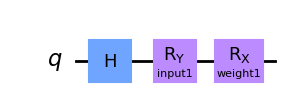

In [2]:
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit

params1 = [Parameter("input1"), Parameter("weight1")]
qc1 = QuantumCircuit(1)
qc1.h(0)
qc1.ry(params1[0], 0)
qc1.rx(params1[1], 0)
qc1.draw("mpl")

We can now create an observable to define the expectation value computation. If not set, then the `EstimatorQNN` will automatically create the default observable $Z^{\otimes n}$. Here, $n$ is the number of qubits of the quantum circuit.

In this example, we will change things up and use the $Y^{\otimes n}$ observable:

In [3]:
from qiskit.quantum_info import SparsePauliOp

observable1 = SparsePauliOp.from_list([("Y" * qc1.num_qubits, 1)])

Together with the quantum circuit defined above, and the observable we have created, the `EstimatorQNN` constructor takes in the following keyword arguments:

- `estimator`: optional primitive instance
- `input_params`: list of quantum circuit parameters that should be treated as "network inputs"
- `weight_params`: list of quantum circuit parameters that should be treated as "network weights"

In this example, we previously decided that the first parameter of `params1` should be the input, while the second should be the weight. As we are performing a local statevector simulation, we will not set the `estimator` parameter; the network will create an instance of the reference `Estimator` primitive for us. If we needed to access cloud resources or `Aer` simulators, we would have to define the respective `Estimator` instances and pass them to the `EstimatorQNN`.

In [4]:
from qiskit_machine_learning.neural_networks import EstimatorQNN

estimator_qnn = EstimatorQNN(
    circuit=qc1, observables=observable1, input_params=[params1[0]], weight_params=[params1[1]]
)
estimator_qnn

We'll see how to use the QNN in the following sections, but before that, let's check out the `SamplerQNN` class.

### 2.2. `SamplerQNN`

The `SamplerQNN` is instantiated in a similar way to the `EstimatorQNN`, but because it directly consumes samples from measuring the quantum circuit, it does not require a custom observable.

These output samples are interpreted by default as the probabilities of measuring the integer index corresponding to a bitstring. However, the `SamplerQNN` also allows us to specify an `interpret` function to post-process the samples. This function should be defined so that it takes a measured integer (from a bitstring) and maps it to a new value, i.e. non-negative integer.

**(!)** It's important to note that if a custom `interpret` function is defined, the `output_shape` cannot be inferred by the network, and **needs to be provided explicitly**.

**(!)** It's also important to keep in mind that if no `interpret` function is used, the dimension of the probability vector will scale exponentially with the number of qubits. With a custom `interpret` function, this scaling can change. If, for instance, an index is mapped to the parity of the corresponding bitstring, i.e., to 0 or 1, the result will be a probability vector of length 2 independently of the number of qubits.

Let's create a different quantum circuit for the `SamplerQNN`. In this case, we will have two input parameters and four trainable weights that parametrize a  two-local circuit.

input parameters: ['input[0]', 'input[1]']
weight parameters: ['weight[0]', 'weight[1]', 'weight[2]', 'weight[3]']


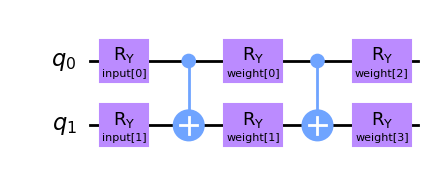

In [5]:
from qiskit.circuit import ParameterVector

inputs2 = ParameterVector("input", 2)
weights2 = ParameterVector("weight", 4)
print(f"input parameters: {[str(item) for item in inputs2.params]}")
print(f"weight parameters: {[str(item) for item in weights2.params]}")

qc2 = QuantumCircuit(2)
qc2.ry(inputs2[0], 0)
qc2.ry(inputs2[1], 1)
qc2.cx(0, 1)
qc2.ry(weights2[0], 0)
qc2.ry(weights2[1], 1)
qc2.cx(0, 1)
qc2.ry(weights2[2], 0)
qc2.ry(weights2[3], 1)

qc2.draw(output="mpl")

Similarly to the `EstimatorQNN`, we must specify inputs and weights when instantiating the `SamplerQNN`. In this case, the keyword arguments will be:
- `sampler`: optional primitive instance
- `input_params`: list of quantum circuit parameters that should be treated as "network inputs"
- `weight_params`: list of quantum circuit parameters that should be treated as "network weights"

Please note that, once again, we are choosing not to set the `Sampler` instance to the QNN and relying on the default.

In [6]:
from qiskit_machine_learning.neural_networks import SamplerQNN

sampler_qnn = SamplerQNN(circuit=qc2, input_params=inputs2, weight_params=weights2)
sampler_qnn

In addition to the basic arguments shown above, the `SamplerQNN` accepts three more settings: `input_gradients`, `interpret`, and `output_shape`. These will be introduced in sections 4 and 5.

# Neural Network Classifier & Regressor

In this tutorial we show how the `NeuralNetworkClassifier` and `NeuralNetworkRegressor` are used.
Both take as an input a (Quantum) `NeuralNetwork` and leverage it in a specific context.
In both cases we also provide a pre-configured variant for convenience, the Variational Quantum Classifier (`VQC`) and Variational Quantum Regressor (`VQR`). The tutorial is structured as follows:


1. [Classification](#Classification) 
    * Classification with a `SamplerQNN`
    * Variational Quantum Classifier (`VQC`)
    
    
2. [Regression](#Regression)
    * Regression with an `EstimatorQNN`
    * Variational Quantum Regressor (`VQR`)

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN

algorithm_globals.random_seed = 42

## Classification

We prepare a simple classification dataset to illustrate the following algorithms.

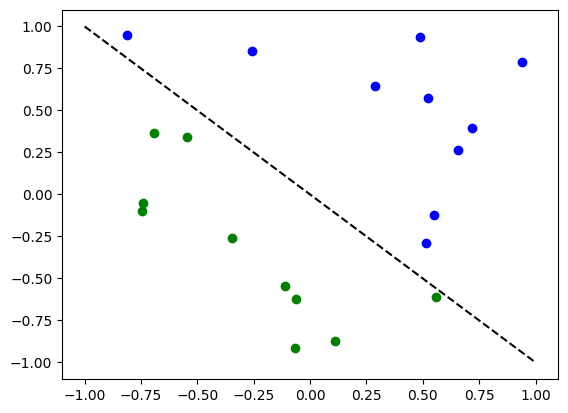

In [12]:
num_inputs = 2
num_samples = 20
X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
y01 = 1 * (np.sum(X, axis=1) >= 0)  # in { 0,  1}
y = 2 * y01 - 1  # in {-1, +1}
y_one_hot = np.zeros((num_samples, 2))
for i in range(num_samples):
    y_one_hot[i, y01[i]] = 1

for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

### Classification with a `SamplerQNN`

We show how a `SamplerQNN` can be used for classification within a `NeuralNetworkClassifier`. In this context, the `SamplerQNN` is expected to return $d$-dimensional probability vector as output, where $d$ denotes the number of classes. 
The underlying `Sampler` primitive returns quasi-distributions of bit strings and we just need to define a mapping from the measured bitstrings to the different classes. For binary classification we use the parity mapping.

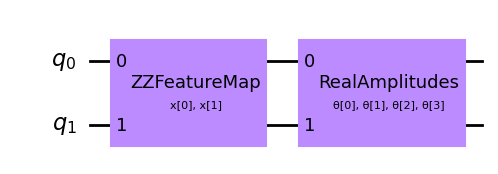

In [13]:
# construct feature map
feature_map = ZZFeatureMap(num_inputs)

# construct ansatz
ansatz = RealAmplitudes(num_inputs, reps=1)

# construct quantum circuit
qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))
qc.decompose().draw(output="mpl")

In [14]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % 2


output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.

In [15]:
# construct QNN
sampler_qnn = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=output_shape,
)

We will add a callback function called `callback_graph`. This will be called for each iteration of the optimizer and will be passed two parameters: the current weights and the value of the objective function at those weights. For our function, we append the value of the objective function to an array so we can plot iteration versus objective function value and update the graph with each iteration. However, you can do whatever you want with a callback function as long as it gets the two parameters mentioned passed. 

In [18]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [19]:
# construct classifier
sampler_classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn, optimizer=COBYLA(maxiter=30), callback=callback_graph
)

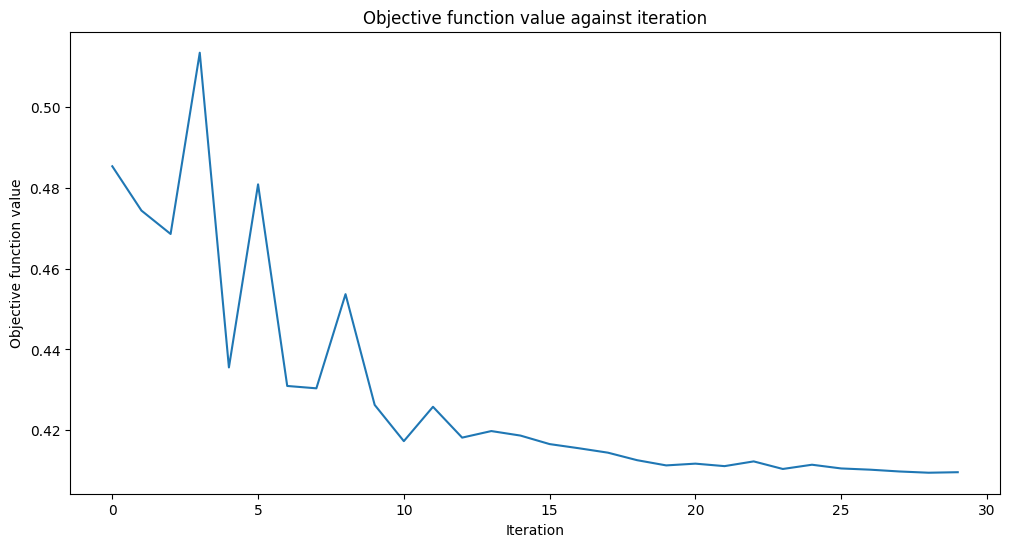

0.8

In [20]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
sampler_classifier.fit(X, y01)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
sampler_classifier.score(X, y01)

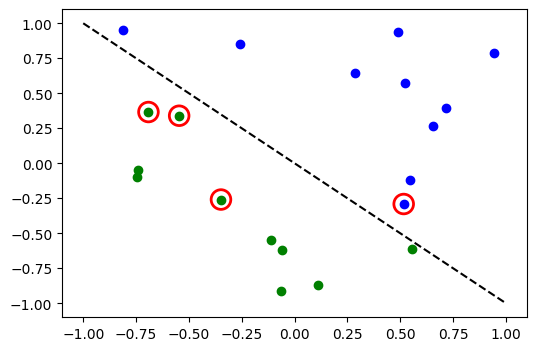

In [21]:
# evaluate data points
y_predict = sampler_classifier.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

In [22]:
#once the model is trained we can take a look at the weights
sampler_classifier.weights

array([1.60472823, 2.90039019, 0.90542691, 1.87323588])

### Variational Quantum Classifier (`VQC`)

The `VQC` is a special variant of the `NeuralNetworkClassifier` with a `SamplerQNN`. It applies a parity mapping (or extensions to multiple classes) to map from the bitstring to the classification, which results in a probability vector, which is interpreted as a one-hot encoded result. By default, it applies this the `CrossEntropyLoss` function that expects labels given in one-hot encoded format and will return predictions in that format too.

In [23]:
# construct feature map, ansatz, and optimizer
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs, reps=1)

# construct variational quantum classifier
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer=COBYLA(maxiter=30),
    callback=callback_graph,
)

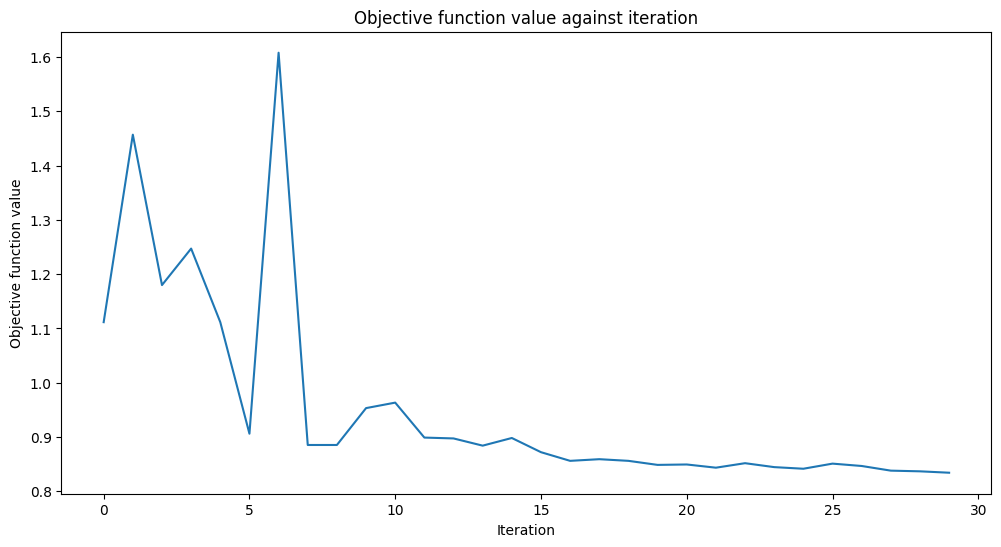

0.65

In [24]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(X, y_one_hot)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(X, y_one_hot)

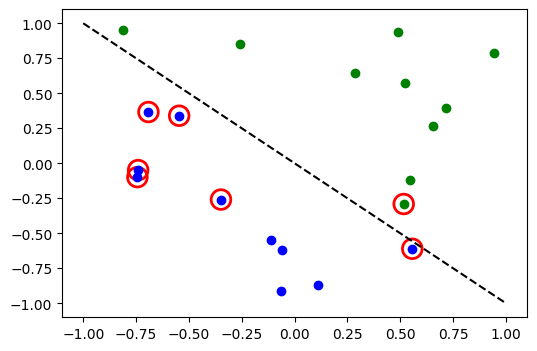

In [25]:
# evaluate data points
y_predict = vqc.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y_one_hot, y_predict):
    if y_target[0] == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if not np.all(y_target == y_p):
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

## Regression

We prepare a simple regression dataset to illustrate the following algorithms.

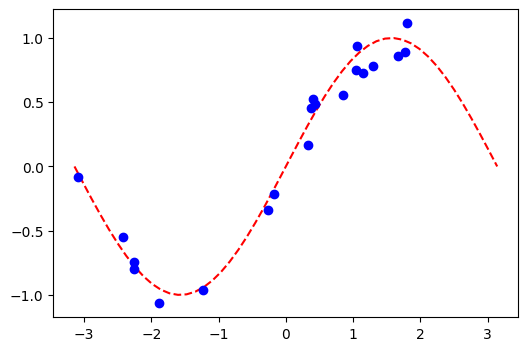

In [26]:
num_samples = 20
eps = 0.2
lb, ub = -np.pi, np.pi
X_ = np.linspace(lb, ub, num=50).reshape(50, 1)
f = lambda x: np.sin(x)

X = (ub - lb) * algorithm_globals.random.random([num_samples, 1]) + lb
y = f(X[:, 0]) + eps * (2 * algorithm_globals.random.random(num_samples) - 1)

plt.plot(X_, f(X_), "r--")
plt.plot(X, y, "bo")
plt.show()

### Regression with an `EstimatorQNN`

Here we restrict to regression with an `EstimatorQNN` that returns values in $[-1, +1]$. More complex and also multi-dimensional models could be constructed, also based on `SamplerQNN` but that exceeds the scope of this tutorial.

In [27]:
# construct simple feature map
param_x = Parameter("x")
feature_map = QuantumCircuit(1, name="fm")
feature_map.ry(param_x, 0)

# construct simple ansatz
param_y = Parameter("y")
ansatz = QuantumCircuit(1, name="vf")
ansatz.ry(param_y, 0)

# construct a circuit
qc = QuantumCircuit(1)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

# construct QNN
regression_estimator_qnn = EstimatorQNN(
    circuit=qc, input_params=feature_map.parameters, weight_params=ansatz.parameters
)

In [28]:
# construct the regressor from the neural network
regressor = NeuralNetworkRegressor(
    neural_network=regression_estimator_qnn,
    loss="squared_error",
    optimizer=L_BFGS_B(maxiter=5),
    callback=callback_graph,
)

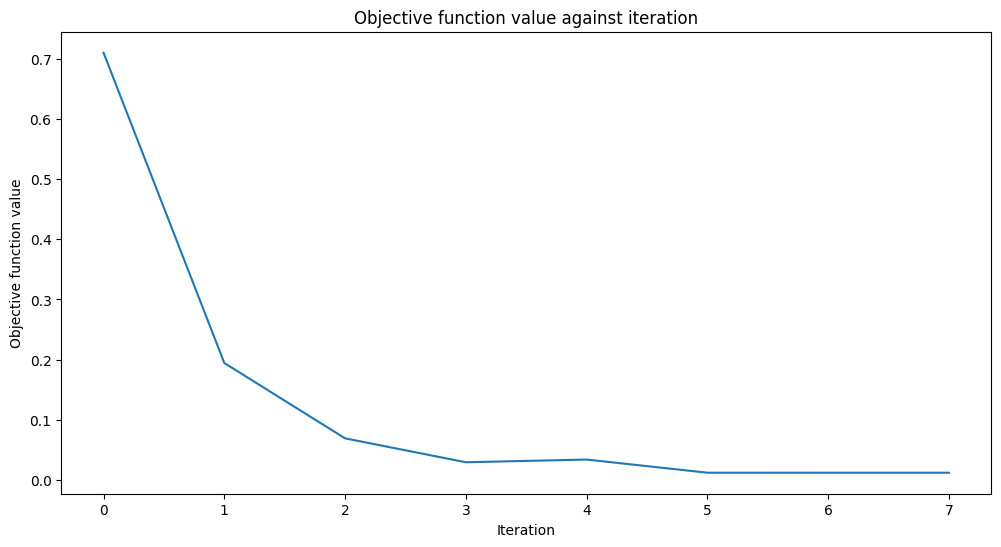

0.9742805027977753

In [29]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit to data
regressor.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score the result
regressor.score(X, y)

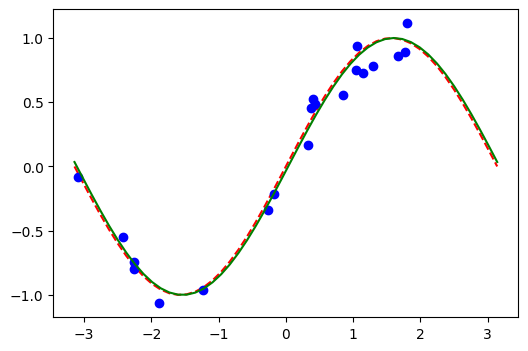

In [30]:
# plot target function
plt.plot(X_, f(X_), "r--")

# plot data
plt.plot(X, y, "bo")

# plot fitted line
y_ = regressor.predict(X_)
plt.plot(X_, y_, "g-")
plt.show()

# Quantum Kernel Machine Learning

## Overview

The general task of machine learning is to find and study patterns in data. For many datasets, the datapoints are better understood in a higher dimensional feature space. This is the fundamental principle behind a series of machine learning algorithms known as *kernel methods*.

In this notebook, you will learn how to define quantum kernels using `qiskit-machine-learning` and how these can be plugged into different algorithms to solve classification and clustering problems.

All examples used in this tutorial are based on this reference paper: [_Supervised learning with quantum enhanced feature spaces_](https://arxiv.org/pdf/1804.11326.pdf).

The content is structured as follows:

1. [Introduction](#1.-Introduction)
2. [Classification](#2.-Classification)

## 1. Introduction

### 1.1. Kernel Methods for Machine Learning

Kernel methods are a collection of pattern analysis algorithms that use kernel functions to operate in a high-dimensional feature space. The best-known application of kernel methods is in **Support Vector Machines (SVMs)**, supervised learning algorithms commonly used for classification tasks. The main goal of SVMs is to find decision boundaries to separate a given set of data points into classes. When these data spaces are not linearly separable, SVMs can benefit from the use of kernels to find these boundaries.

Formally, decision boundaries are hyperplanes in a high dimensional space. The kernel function implicitly maps input data into this higher dimensional space, where it can be easier to solve the initial problem. In other words, kernels may allow data distributions that were originally non-linearly separable to become a linearly separable problem. This is an effect known as the "kernel trick".

There are use-cases for kernel-based unsupervised algorithms too, for example, in the context of clustering. **Spectral Clustering** is a technique where data points are treated as nodes of a graph, and the clustering task is viewed as a graph partitioning problem where nodes are mapped to a space where they can be easily segregated to form clusters.



### 1.2. Kernel Functions

Mathematically, kernel functions follow:

$k(\vec{x}_i, \vec{x}_j) = \langle f(\vec{x}_i), f(\vec{x}_j) \rangle$

where 
* $k$ is the kernel function
* $\vec{x}_i, \vec{x}_j$ are $n$ dimensional inputs
* $f$ is a map from $n$-dimension to $m$-dimension space and 
* $\langle a,b \rangle$ denotes the inner product

When considering finite data, a kernel function can be represented as a matrix: 

$K_{ij} = k(\vec{x}_i,\vec{x}_j)$.



### 1.3. Quantum Kernels

The main idea behind quantum kernel machine learning is to leverage quantum feature maps to perform the kernel trick. In this case, the quantum kernel is created by mapping a classical feature vector $\vec{x}$ to a Hilbert space using a quantum feature map $\phi(\vec{x})$. Mathematically:

$K_{ij} = \left| \langle \phi(\vec{x}_i)| \phi(\vec{x}_j) \rangle \right|^{2}$

where 
* $K_{ij}$ is the kernel matrix
* $\vec{x}_i, \vec{x}_j$ are $n$ dimensional inputs
* $\phi(\vec{x})$ is the quantum feature map
* $\left| \langle a|b \rangle \right|^{2}$ denotes the overlap of two quantum states $a$ and $b$

Quantum kernels can be plugged into common classical kernel learning algorithms such as SVMs or clustering algorithms, as you will see in the examples below. They can also be leveraged in new quantum kernel methods like `QSVC` [class](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.algorithms.QSVC.html) provided by `qiskit-machine-learning` which is explored in this tutorial, and other methods as shown in later tutorials on [Pegasos QSVC](https://github.com/Qiskit/qiskit-machine-learning/blob/main/docs/tutorials/07_pegasos_qsvc.ipynb) and [QKA](https://github.com/Qiskit/qiskit-machine-learning/blob/main/docs/tutorials/08_quantum_kernel_trainer.ipynb).

***

Before introducing any example, we set up the global seed to ensure reproducibility:

In [31]:
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 12345

## 2. Classification

This section illustrates a quantum kernel classification workflow using `qiskit-machine-learning`.

### 2.1. Defining the dataset

For this example, we will use the _ad hoc dataset_ as described in the reference [paper](https://arxiv.org/pdf/1804.11326.pdf). 

We can define the dataset dimension and get our train and test subsets:

In [32]:
from qiskit_machine_learning.datasets import ad_hoc_data

adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=20,
    test_size=5,
    n=adhoc_dimension,
    gap=0.3,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)

This dataset is two-dimensional, the two features are represented by the $x$ and $y$ coordinates, and it has two class labels: A and B. We can plot it and see what the distribution looks like. We define utility functions to plot the dataset.

In [33]:
import matplotlib.pyplot as plt
import numpy as np


def plot_features(ax, features, labels, class_label, marker, face, edge, label):
    # A train plot
    ax.scatter(
        # x coordinate of labels where class is class_label
        features[np.where(labels[:] == class_label), 0],
        # y coordinate of labels where class is class_label
        features[np.where(labels[:] == class_label), 1],
        marker=marker,
        facecolors=face,
        edgecolors=edge,
        label=label,
    )



In [34]:
def plot_dataset(train_features, train_labels, test_features, test_labels, adhoc_total):

    plt.figure(figsize=(5, 5))
    plt.ylim(0, 2 * np.pi)
    plt.xlim(0, 2 * np.pi)
    plt.imshow(
        np.asmatrix(adhoc_total).T,
        interpolation="nearest",
        origin="lower",
        cmap="RdBu",
        extent=[0, 2 * np.pi, 0, 2 * np.pi],
    )

    # A train plot
    plot_features(plt, train_features, train_labels, 0, "s", "w", "b", "A train")

    # B train plot
    plot_features(plt, train_features, train_labels, 1, "o", "w", "r", "B train")

    # A test plot
    plot_features(plt, test_features, test_labels, 0, "s", "b", "w", "A test")

    # B test plot
    plot_features(plt, test_features, test_labels, 1, "o", "r", "w", "B test")

    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
    plt.title("Ad hoc dataset")

    plt.show()

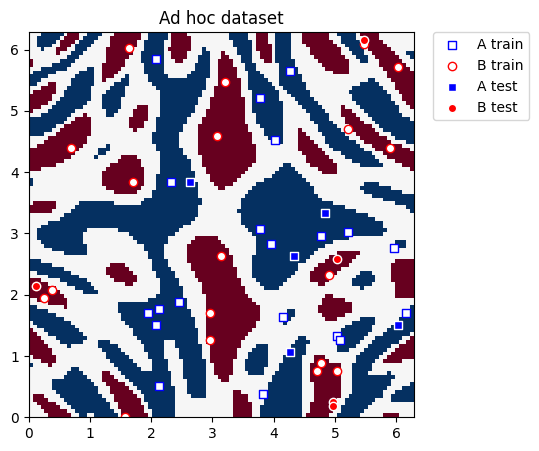

In [35]:
plot_dataset(train_features, train_labels, test_features, test_labels, adhoc_total)

### 2.2. Defining the quantum kernel

The next step is to create a quantum kernel instance that will help classify this data. 

We use the `FidelityQuantumKernel` [class](https://github.com/Qiskit/qiskit-machine-learning/blob/main/qiskit_machine_learning/kernels/fidelity_quantum_kernel.py), and pass two input arguments to its constructor: 

1. `feature_map`: in this case, a two-qubit `ZZFeatureMap` [instance](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html).

2. `fidelity`: in this case, the `ComputeUncompute` [fidelity](https://qiskit.org/documentation/stubs/qiskit.algorithms.state_fidelities.ComputeUncompute.html) subroutine that leverages the `Sampler` [primitive](https://qiskit.org/documentation/stubs/qiskit.primitives.Sampler.html).

**NOTE:** If you don't pass a `Sampler` or `Fidelity` instance, then the instances of the reference `Sampler` and `ComputeUncompute` classes (found in `qiskit.primitives`) will be created by default.

In [36]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=2, entanglement="linear")

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=adhoc_feature_map)

### 2.3. Classification with SVC
The quantum kernel can now be plugged into classical kernel methods, such as the `SVC` [algorithm](https://scikit-learn.org/stable/modules/svm.html) from `scikit-learn`. This algorithm allows us to define a [custom kernel](https://scikit-learn.org/stable/modules/svm.html#custom-kernels) in two ways: 
1. by providing the kernel as a **callable function**
2. by precomputing the **kernel matrix**

#### Precomputed kernel matrix

Instead of passing a function of the quantum kernel as a callable, we can also precompute training and testing kernel matrices before passing them to the `scikit-learn` `SVC` algorithm. 

To extract the train and test matrices, we can call `evaluate` on the previously defined kernel and visualize them graphically as follows:

In [37]:
adhoc_matrix_train = adhoc_kernel.evaluate(x_vec=train_features)
adhoc_matrix_test = adhoc_kernel.evaluate(x_vec=test_features, y_vec=train_features)

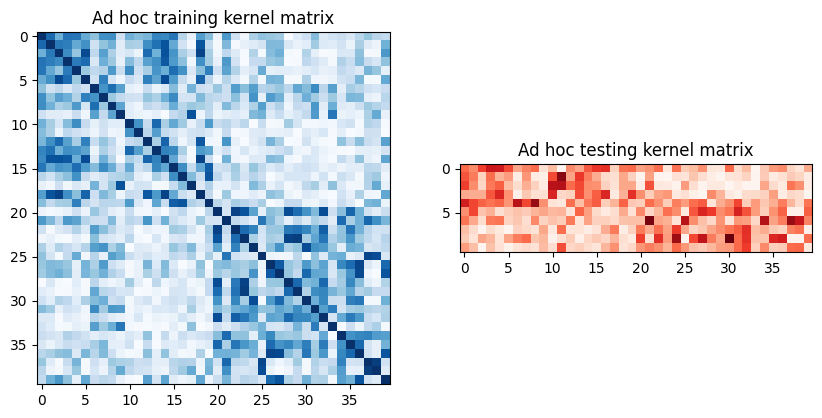

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(
    np.asmatrix(adhoc_matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Ad hoc training kernel matrix")

axs[1].imshow(np.asmatrix(adhoc_matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Ad hoc testing kernel matrix")

plt.show()

To use these matrices, we set the `kernel` parameter of a new `SVC` instance to `"precomputed"`. We train the classifier by calling `fit` with the training matrix and training dataset. Once the model is trained, we evaluate it using the test matrix on the test dataset.

In [40]:
from sklearn.svm import SVC

adhoc_svc = SVC(kernel="precomputed")

adhoc_svc.fit(adhoc_matrix_train, train_labels)

adhoc_score_precomputed_kernel = adhoc_svc.score(adhoc_matrix_test, test_labels)

print(f"Precomputed kernel classification test score: {adhoc_score_precomputed_kernel}")

Precomputed kernel classification test score: 1.0
